In [138]:
import sys
ENABLE_GOOGLE_COLAB = 'google.colab' in sys.modules
ENABLE_GOOGLE_COLAB

False

In [139]:
if ENABLE_GOOGLE_COLAB:
  # Instalación de API de Google Drive para utilizar archivos en la nube
  !pip install -U -q PyDrive
  # Instala h5py
  !pip install h5py
  # Instala plot.ly
  !pip install plotly
  # TA-Lib: instalación y carga de la librería
  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  !make
  !make install
  !pip install Ta-Lib
  # Instalación de ngrok para visualización en tensorboard
  !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
  !unzip ngrok-stable-linux-amd64.zip
  from google.colab import auth
  from google.colab import files
  
# incluye google drive api
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

# Librerías de manejo de datos 
import pandas as pd
from pandas import concat
import numpy as np

# Librerías de machine learning
import sklearn
from sklearn import preprocessing
from sklearn import metrics as sk
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

# Librerías de visualización
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Layout
import plotly.tools as tls
tls.set_credentials_file(username='raulMrello', api_key='qX9S30YRQ866mGF9b89u')

# TA-Lib: instalación y carga de la librería
import talib

# Otras utilidades
import datetime
import time
import os
import sys

print('Done!')

Done!


In [140]:
# 1. Autenticación en Google Drive
if ENABLE_GOOGLE_COLAB:
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  #2. Obtiene el archivo
  downloaded = drive.CreateFile({'id':'1xuDgK4FteolMBiaYVRNWaofw36iQyRaV'}) # replace the id with id of file you want to access
  downloaded.GetContentFile('EURUSD_M30.csv')  


In [141]:
s = list()
x = 2*np.pi/100
for i in range(1000):    
    s.append(0.5 + np.sin(0.8*x*i)+np.cos(0.45*x*i))    

dfapp = pd.DataFrame(data=np.asarray(s), columns=['inp'])
dfapp['out'] = dfapp['inp']
dfapp['shift'] = dfapp['inp'].shift(-1) - dfapp['inp']
dfapp.dropna(inplace=True)
dfapp['rare'] = dfapp['shift']/dfapp['inp']
dfapp = dfapp[['inp','shift','rare','out']]
num_outputs = 1
num_inputs = len(dfapp.columns) - num_outputs
dfapp.head()


,inp,shift,rare,out
0,1.500000,0.049845,0.033230,1.500000
1,1.549845,0.048919,0.031564,1.549845
2,1.598763,0.047867,0.029940,1.598763
3,1.646630,0.046691,0.028355,1.646630
4,1.693321,0.045392,0.026807,1.693321


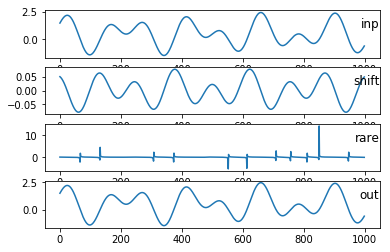

In [142]:
# Visualiza con Matplotlib
# Visualiza 
val = dfapp.values
plt.figure()
for col in range(len(dfapp.columns)):
	plt.subplot(len(dfapp.columns), 1, col+1)
	plt.plot(val[:, col])
	plt.title(dfapp.columns[col], y=0.5, loc='right')
plt.show()

In [143]:
def series_to_supervised(df, num_inputs, num_outputs, n_in=1, n_out=1, dropnan=True):
  # obtengo el dataframe con las entradas y las salidas
  df_in = df[[x for x in df.columns if df.columns.get_loc(x) < num_inputs]]
  df_out = df[[x for x in df.columns if df.columns.get_loc(x)>=num_inputs]]
  
  cols, names = list(), list()
	# input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df_in.shift(i))
    names += [('%s(t-%d)' % (df_in.columns[j], i)) for j in range(0, num_inputs)]
    
	# forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):   
    cols.append(df_out.shift(-i))
    if i == 0:
      names += [('%s(t)' % (df_out.columns[j])) for j in range(0, num_outputs)]
    else:
      names += [('%s(t+%d)' % (df_out.columns[j], i)) for j in range(0, num_outputs)]
  # put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

# Creo columnas para las 24 muestras de entradas t-1, ..., t-48 y para las dos salidas t, t+1
num_in_steps = 24
num_out_steps = 2
sts_df = series_to_supervised(dfapp, num_inputs, num_outputs, num_in_steps, num_out_steps)
print('Número de muestras total: ', sts_df.shape[0])
sts_df.head()

Número de muestras total:  974


,inp(t-24),shift(t-24),rare(t-24),inp(t-23),shift(t-23),rare(t-23),inp(t-22),shift(t-22),rare(t-22),inp(t-21),...,shift(t-3),rare(t-3),inp(t-2),shift(t-2),rare(t-2),inp(t-1),shift(t-1),rare(t-1),out(t),out(t+1)
24,1.500000,0.049845,0.033230,1.549845,0.048919,0.031564,1.598763,0.047867,0.029940,1.646630,...,0.007510,0.003415,2.206536,0.004602,0.002086,2.211138,0.001654,0.000748,2.212791,2.211462
25,1.549845,0.048919,0.031564,1.598763,0.047867,0.029940,1.646630,0.046691,0.028355,1.693321,...,0.004602,0.002086,2.211138,0.001654,0.000748,2.212791,-0.001329,-0.000600,2.211462,2.207123
26,1.598763,0.047867,0.029940,1.646630,0.046691,0.028355,1.693321,0.045392,0.026807,1.738714,...,0.001654,0.000748,2.212791,-0.001329,-0.000600,2.211462,-0.004339,-0.001962,2.207123,2.199753
27,1.646630,0.046691,0.028355,1.693321,0.045392,0.026807,1.738714,0.043973,0.025290,1.782686,...,-0.001329,-0.000600,2.211462,-0.004339,-0.001962,2.207123,-0.007371,-0.003339,2.199753,2.189336
28,1.693321,0.045392,0.026807,1.738714,0.043973,0.025290,1.782686,0.042434,0.023804,1.825121,...,-0.004339,-0.001962,2.207123,-0.007371,-0.003339,2.199753,-0.010417,-0.004735,2.189336,2.175865


In [144]:
# Creo los scalers de cada columna (entradas y salidas)
values = sts_df.values
values = values.astype('float32')
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
values = scaler.fit_transform(values)

# actualizo el dataframe
sts_df = pd.DataFrame(data=values, columns=sts_df.columns)
sts_values = sts_df.values
sts_df.head()


,inp(t-24),shift(t-24),rare(t-24),inp(t-23),shift(t-23),rare(t-23),inp(t-22),shift(t-22),rare(t-22),inp(t-21),...,shift(t-3),rare(t-3),inp(t-2),shift(t-2),rare(t-2),inp(t-1),shift(t-1),rare(t-1),out(t),out(t+1)
0,0.508373,0.653139,-0.449243,0.533713,0.641172,-0.449414,0.558582,0.627581,-0.449579,0.582916,...,0.106017,-0.452288,0.867557,0.068440,-0.452424,0.869897,0.030339,-0.452560,0.870737,0.870062
1,0.533713,0.641172,-0.449414,0.558582,0.627581,-0.449579,0.582916,0.612383,-0.449741,0.606653,...,0.068440,-0.452424,0.869897,0.030339,-0.452560,0.870737,-0.008205,-0.452698,0.870062,0.867856
2,0.558582,0.627581,-0.449579,0.582916,0.612383,-0.449741,0.606653,0.595598,-0.449899,0.629729,...,0.030339,-0.452560,0.870737,-0.008205,-0.452698,0.870062,-0.047109,-0.452837,0.867856,0.864109
3,0.582916,0.612383,-0.449741,0.606653,0.595598,-0.449899,0.629729,0.577251,-0.450054,0.652083,...,-0.008205,-0.452698,0.870062,-0.047109,-0.452837,0.867856,-0.086288,-0.452978,0.864109,0.858813
4,0.606653,0.595598,-0.449899,0.629729,0.577251,-0.450054,0.652083,0.557371,-0.450206,0.673656,...,-0.047109,-0.452837,0.867856,-0.086288,-0.452978,0.864109,-0.125656,-0.453120,0.858813,0.851965


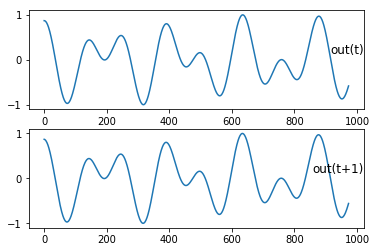

In [145]:
# Visualiza muestras en Matplotlib
plt.figure()
items = num_outputs*num_out_steps
icol = 1
for col in range(len(sts_df.columns)-items, len(sts_df.columns)):
  plt.subplot(items, 1, icol)
  plt.plot(values[:, col])
  plt.title(sts_df.columns[col], y=0.5, loc='right')
  icol += 1

In [146]:
def walk_forward(df, wf_train, wf_test, wf_validate):
    values = df.values
    print('Procesando df con {} registros...'.format(values.shape[0]))
    print('walkforward train={}, test={}, validate={}'.format(wf_train, wf_test, wf_validate))
    # calculo el número de muestras del walk-forward (wf_size) en base a los wf de entrenamiento y test
    wf_size = wf_train + wf_test + wf_validate
    # creo arrays para obtener los conjuntos de entranamiento y test
    nd_train=[]
    nd_test=[]
    nd_validate=[]
    # creo un bucle mientras que esté en el rango del número de muestras a procesar
    for i in range(0,values.shape[0],wf_test):
        if i==0:
            nd_train = values[0:wf_train,:]
            nd_test = values[wf_train:wf_train+wf_test,:]  
            nd_validate = values[wf_train+wf_test:wf_size,:]  
            print('Iniciados train.shape={}, test.shape={}, validation.shape={}'.format(nd_train.shape, nd_test.shape, nd_validate.shape))
        # si el punto final de este lote está fuera de rango, lo reajusto y termino
        elif i+wf_size >= values.shape[0]:
            nd_train = np.append(nd_train, values[-wf_size:-(wf_size+wf_train),:] , axis=0)
            nd_test = np.append(nd_test, values[-(wf_size+wf_train):-(wf_size+wf_train+wf_test),:] , axis=0)
            nd_validate = np.append(nd_validate, values[-wf_validate:,:] , axis=0)
            #print('Añadidos train[{},{}] y test[{},{}]'.format(values.shape[0]-wf_size, values.shape[0]-wf_test-1,values.shape[0]-wf_test,values.shape[0]-1))
            break    
        # el resto de casos, se van añadiendo datos a los conjuntos de entrenamiento y test
        else:
            nd_train = np.append(nd_train, values[i:i+wf_train,:] , axis=0)
            nd_test = np.append(nd_test, values[i+wf_train:i+wf_train+wf_test,:] , axis=0)
            nd_validate = np.append(nd_validate, values[i+wf_train+wf_test:i+wf_size,:] , axis=0)
            #print('Añadidos train[{},{}] y test[{},{}]'.format(i,i+wf_train-1,i+wf_train,i+wf_size-1))
    print('train.shape={}, test.shape={}, validate.shape={}'.format(nd_train.shape, nd_test.shape, nd_validate.shape))
    return nd_train,nd_test,nd_validate

  
xdf = sts_df.copy()
wf_size = np.floor(xdf.shape[0]/100)
wf_train = int(np.floor(wf_size * 0.6))
wf_test = int(np.floor(wf_size * 0.2))
wf_validate = int(wf_size - wf_train - wf_test)
train,test,validation = walk_forward(xdf, wf_train, wf_test, wf_validate) 

Procesando df con 974 registros...
walkforward train=5, test=1, validate=3
Iniciados train.shape=(5, 74), test.shape=(1, 74), validation.shape=(3, 74)
train.shape=(4825, 74), test.shape=(965, 74), validate.shape=(2898, 74)


In [147]:
num_train_samples = int(train.shape[0])
num_test_samples = int(test.shape[0])
num_validation_samples = int(validation.shape[0])

# obtengo los pares x-y de cada conjunto
x_train, y_train = train[:,:-(num_outputs * num_out_steps)], train[:,-(num_outputs * num_out_steps):]
x_test, y_test = test[:,:-(num_outputs * num_out_steps)], test[:,-(num_outputs * num_out_steps):]
x_validation, y_validation = validation[:,:-(num_outputs * num_out_steps)], validation[:,-(num_outputs * num_out_steps):]
print('X Train shape:', x_train.shape, ' Y Train shape:', y_train.shape, '\r\n')
print('X Test shape:', x_test.shape, ' Y Test shape:', y_test.shape, '\r\n')
print('X Validation shape:', x_validation.shape, ' Y Validation shape:', y_validation.shape, '\r\n')
print('----------------------------------------------------------------------')

# acondiciono los formatos a la entrada LSTM (num_samples, num_steps, num_features)
x_train = x_train.reshape((x_train.shape[0], num_in_steps, num_inputs))
x_test = x_test.reshape((x_test.shape[0], num_in_steps, num_inputs))
x_validation = x_validation.reshape((x_validation.shape[0], num_in_steps, num_inputs))

print('X Train reshape:', x_train.shape, ' Y Train reshape:', y_train.shape, '\r\n')
print('X Test reshape:', x_test.shape, ' Y Test reshape:', y_test.shape, '\r\n')
print('X Validation reshape:', x_validation.shape, ' Y Validation reshape:', y_validation.shape, '\r\n')

X Train shape: (4825, 72)  Y Train shape: (4825, 2) 

X Test shape: (965, 72)  Y Test shape: (965, 2) 

X Validation shape: (2898, 72)  Y Validation shape: (2898, 2) 

----------------------------------------------------------------------
X Train reshape: (4825, 24, 3)  Y Train reshape: (4825, 2) 

X Test reshape: (965, 24, 3)  Y Test reshape: (965, 2) 

X Validation reshape: (2898, 24, 3)  Y Validation reshape: (2898, 2) 



In [148]:
# callback para hacer backup de los pesos en el ordenador local
class DownloadWeights(keras.callbacks.Callback):
  def __init__(self, filepath):
    self.filepath = filepath
  def on_epoch_end(self, epoch, logs={}):
    model_json = self.model.to_json()
    with open("model_test.json", "w") as json_file:
      json_file.write(model_json)
    # Serializa los pesos a formato HDF5
    self.model.save_weights(self.filepath)
    # Descargo el archivo al ordenador local
    files.download(self.filepath)    
    print("Saved model to disk")
    return
  '''
  def on_train_begin(self, logs={}):
    pass
  def on_train_end(self, logs={}):
    return
  def on_batch_begin(self, batch, logs={}):
    return
  def on_batch_end(self, batch, logs={}):
    return
  def on_epoch_begin(self, epoch, logs={}):
    return
  '''

# callback para hacer backup de los pesos en el ordenador local
class FitLogger(keras.callbacks.Callback):
  def __init__(self, fitfile):
    self.fitfile = fitfile
    self.loss, self.val_loss, self.acc, self.val_acc = np.ndarray((0,)), np.ndarray((0,)),np.ndarray((0,)), np.ndarray((0,))
    dfx = pd.DataFrame(data=[[0],[0],[0],[0]]).transpose()
    dfx.columns=['loss','val_loss','acc','val_acc']
    dfx.to_csv(self.fitfile)
    print('file "{}" updated'.format(self.fitfile))

  '''
  def on_epoch_end(self, epoch, logs={}):
    return
  def on_train_begin(self, logs={}):
    pass
  def on_train_end(self, logs={}):
    return
  def on_epoch_begin(self, epoch, logs={}):
    return
  def on_batch_begin(self, batch, logs={}):
    print('Starting batch...')
    return
  def on_batch_end(self, batch, logs={}):
    print('... batch Finished!')
    return
  def on_epoch_begin(self, epoch, logs={}):
    print('Starting epoch...', epoch)
    return
  '''
  def on_epoch_end(self, epoch, logs={}):
    self.loss = np.append(self.loss, [logs.get('loss')], axis=0)
    self.val_loss = np.append(self.val_loss, [logs.get('val_loss')], axis=0)
    self.acc = np.append(self.acc, [logs.get('acc')], axis=0)
    self.val_acc = np.append(self.val_acc, [logs.get('val_acc')], axis=0)
    s0,s1,s2,s3 = pd.Series(self.loss), pd.Series(self.val_loss), pd.Series(self.acc[-self.loss.shape[0]:]), pd.Series(self.val_acc[-self.loss.shape[0]:])
    dfx = pd.DataFrame(data=[s0,s1,s2,s3]).transpose()
    dfx.columns=['loss','val_loss','acc','val_acc']
    dfx.to_csv(self.fitfile)
    return
  
  

In [149]:
file_weights = "model_weights_test9.hdf5"

In [154]:
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.constraints import max_norm
from keras import backend

# Métrica loss con dependencia del signo
def stock_loss(y_true, y_pred):
    alpha = 100.
    loss = K.switch(K.less(y_true * y_pred, 0), \
        alpha*y_pred**2 - K.sign(y_true)*y_pred + K.abs(y_true), \
        K.abs(y_true - y_pred)
        )
    return K.mean(loss, axis=-1)

# Métrica RMSE
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# Crea un modelo LSTM 
def build_stacked_lstm(num_cells, num_layers, num_inputs, num_in_steps, num_outputs, num_out_steps, batch_size, filepath):
  # Inicio definiendo un modelo secuencial
  model = Sequential()

  sequence_flag = False
  if num_layers > 1:
    sequence_flag = True
    
  # capa de entrada, debe especificar formato 'input_shape'
  model.add(LSTM(num_cells, return_sequences=sequence_flag, input_shape=(num_in_steps, num_inputs)))
  #model.add(BatchNormalization())
  model.add(Dropout(0.20))
  
  for i in range(1, num_layers, 1):
    if i == num_layers-1:
      sequence_flag = False
    # capas intermedias
    model.add(LSTM(num_cells, return_sequences=sequence_flag))
    #model.add(BatchNormalization())
    model.add(Dropout(0.20))
  
  # la capa de salida es una capa Dense con tantas salidas como timesteps a predecir con activación lineal     
  model.add(Dense(num_outputs * num_out_steps, activation='linear'))

  # compilo con optimizador Adam y pérdida 'mse'
  opt = keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=False)
  model.compile(optimizer=opt, loss='mse', metrics=[rmse, 'mae', 'accuracy'])  

  #checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  #download_weights = DownloadWeights(filepath)
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
  fitlogger = FitLogger('fit_test.csv')
  # callback para visualización en tensorboard
  #tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,write_graph=True,write_grads=True,batch_size=batch_size,write_images=True)
  callbacks_list = [checkpoint, fitlogger]  

  # si existe un modelo previo, lo carga
  try:
    model.load_weights(filepath)
    print('Loaded weights from file: ', filepath)
  except:
    print('No weights file to load')
    
  model.summary()
  return model, callbacks_list

num_cells = 128
num_layers = 3
batch_size = 16
model, callbacks_list = build_stacked_lstm(num_cells, num_layers, num_inputs, num_in_steps, num_outputs, num_out_steps, batch_size, file_weights)


file "fit_test.csv" updated
Loaded weights from file:  model_weights_test9.hdf5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 24, 128)           67584     
_________________________________________________________________
dropout_52 (Dropout)         (None, 24, 128)           0         
_________________________________________________________________
lstm_53 (LSTM)               (None, 24, 128)           131584    
_________________________________________________________________
dropout_53 (Dropout)         (None, 24, 128)           0         
_________________________________________________________________
lstm_54 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_54 (Dropout)         (None, 128)               0         
______________________________________________________________

In [155]:
# hago un control de epochs manual
epoch_count = 0
#loss, val_loss, acc, val_acc = np.ndarray((0,)), np.ndarray((0,)),np.ndarray((0,)), np.ndarray((0,))

def save_weights(model, filename, notify=False):
  # Serialización del modelo en formato json
  model_json = model.to_json()
  with open("model_test.json", "w") as json_file:
    json_file.write(model_json)

  # Serializa los pesos a formato HDF5
  model.save_weights(filename)
  if notify:
    print("Saved model to disk")


In [156]:
# Inicia el entrenamiento y validación con los pares de entrenamiento
# para evitar perder los pesos en cierres esporádicos de la conexión del notebook, hago un backup en cada epoch
# de forma manual.
num_epochs = 40
nb_epoch = 40
  
try:
  for i in range(0, num_epochs, nb_epoch):
    print('Iniciando entrenamiento en epoch=',epoch_count)
    history = model.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size, callbacks=callbacks_list, validation_data=(x_test,y_test), verbose=2, shuffle=True) 
    num_epochs += nb_epoch
except:
  print('Model fit Exception:', sys.exc_info()[0])

if ENABLE_GOOGLE_COLAB:
  files.download(file_weights)

  


Iniciando entrenamiento en epoch= 0
Train on 4825 samples, validate on 965 samples
Epoch 1/40
 - 25s - loss: 0.0021 - rmse: 0.0337 - mean_absolute_error: 0.0330 - acc: 0.8570 - val_loss: 4.4341e-04 - val_rmse: 0.0167 - val_mean_absolute_error: 0.0163 - val_acc: 0.9637
Epoch 2/40
 - 17s - loss: 0.0020 - rmse: 0.0330 - mean_absolute_error: 0.0324 - acc: 0.8686 - val_loss: 4.8548e-04 - val_rmse: 0.0182 - val_mean_absolute_error: 0.0178 - val_acc: 0.9503
Epoch 3/40
 - 17s - loss: 0.0019 - rmse: 0.0322 - mean_absolute_error: 0.0315 - acc: 0.8460 - val_loss: 5.5103e-04 - val_rmse: 0.0220 - val_mean_absolute_error: 0.0215 - val_acc: 0.9181
Epoch 4/40
 - 17s - loss: 0.0016 - rmse: 0.0287 - mean_absolute_error: 0.0280 - acc: 0.8682 - val_loss: 0.0010 - val_rmse: 0.0279 - val_mean_absolute_error: 0.0275 - val_acc: 0.8984
Epoch 5/40
 - 17s - loss: 0.0016 - rmse: 0.0287 - mean_absolute_error: 0.0282 - acc: 0.8785 - val_loss: 1.4245e-04 - val_rmse: 0.0100 - val_mean_absolute_error: 0.0093 - val_acc

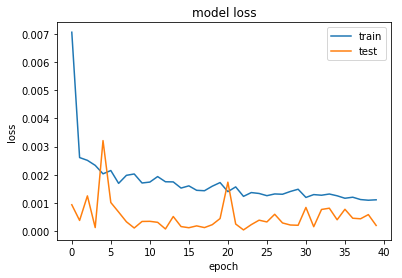

In [134]:
plt.plot(callbacks_list[1].loss[:])
plt.plot(callbacks_list[1].val_loss[:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
epoch_count += num_epochs

In [135]:
# Evalúa el funcionamiento con la partición de evaluación
  scores = model.evaluate(x_validation, y_validation, verbose=2)
  print("Model Accuracy: %.2f%%" % (scores[1]*100))

Model Accuracy: 91.30%


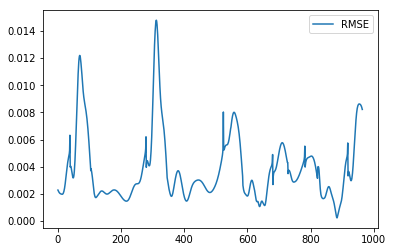

In [136]:
import math

x_data = x_test.copy()
y_data = y_test.copy()

rmse = list()
for sample in range(x_data.shape[0]):
    # Realizo predicción del primer conjunto de datos
    x = x_data[sample].reshape(1, num_in_steps, num_inputs)
    y = y_data[sample].reshape(1,num_outputs * num_out_steps)
    predictions = model.predict(x, batch_size=1,verbose=0)

    # deshago el scaling
    xy_values = np.concatenate((x.reshape(1, x.shape[1]*x.shape[2]), y),axis=1)
    xy_values = scaler.inverse_transform(xy_values)

    xyhat_values = np.concatenate((x.reshape(1, x.shape[1]*x.shape[2]), predictions),axis=1)
    xyhat_values = scaler.inverse_transform(xyhat_values)

    # Calculo el error RMSE
    rmse_val = math.sqrt(sk.mean_squared_error(xy_values[-(num_outputs * num_out_steps):], xyhat_values[-(num_outputs * num_out_steps):], multioutput = 'uniform_average'))
    rmse.append(rmse_val)
    #print('RMSE: %f' % rmse_val)

plt.plot(np.asarray(rmse))    
plt.legend(['RMSE'])


Text(0.5, 1.0, 'EURUSD OHLC en M30')

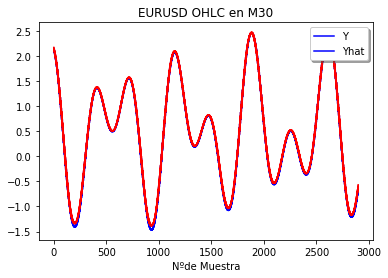

In [137]:
# Una vez validado, realiza las predicciones con las entradas de validación, visualiza y obtiene error
x_eval = x_validation.copy()
x_eval = x_eval.reshape(x_eval.shape[0], num_in_steps, num_inputs)

y_eval = y_validation.copy()
target = list()
result = list()
for i in range(x_eval.shape[0]):
  x = x_eval[i].reshape(1, num_in_steps, num_inputs)
  y = y_eval[i].reshape(1, num_outputs * num_out_steps)
  predictions = model.predict(x, batch_size=1, verbose=0)
  # deshago el scaling
  xy_values = np.concatenate((x.reshape(1, x.shape[1]*x.shape[2]), y),axis=1)
  xy_values = scaler.inverse_transform(xy_values)
  xyhat_values = np.concatenate((x.reshape(1, x.shape[1]*x.shape[2]), predictions),axis=1)
  xyhat_values = scaler.inverse_transform(xyhat_values)
  target.append(xy_values[0,xy_values.shape[1]-(num_outputs * num_out_steps):])
  result.append(xyhat_values[0, xyhat_values.shape[1]-(num_outputs * num_out_steps):])

# visualizo los resultados
plt.plot(np.asarray(target), color='b')
plt.plot(np.asarray(result),color='r')
plt.xlabel('Nºde Muestra')
plt.legend(('Y','Yhat'), loc='upper right', shadow=True)
plt.title('EURUSD OHLC en M30') 
    
